In [29]:
!pip install autograd

from baselines import *
from uncertainty import *
from utils import *

from autograd import numpy as np
from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam, sgd
from sklearn.datasets import make_moons
import numpy.random as npr
import pandas as pd
import numpy 
import scipy as sp
import matplotlib.pyplot as plt
import sys
import os
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


# Experiment 1

In this experiment, our aim is to understand how the different models under
consideration perform on test points that are placed far from the high confidence
part of the decision boundaries. In particular, how well does the uncertainty captured by
each of the models indicate when test points are out of distribution. These engineered 
situations allow us to probe the epistemic uncertainty of the models in regions where 
little to no training data has been seen. 


## The Data Sets

We will consider two test beds for this experiment. First, we will consider points
belonging spacially to two different Gaussian distributions, each with its own class
label. Below, we visualize such a training set, along with our out of distribution test
points in black. 

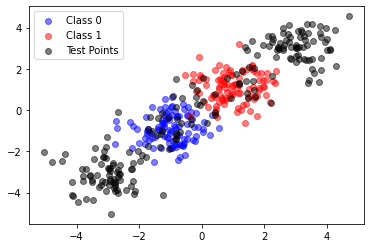

In [2]:
# Generate a toy dataset for classification (Gaussian Blobs)
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x_train = np.vstack((class_0, class_1))
y_train = np.array([0] * 100 + [1] * 100)

# generate test points, include some of original training distribution
test_points, test_points_labels = generate_exp1_test_data()

plot_training_data(x_train, y_train, samples, test=test_points)


The second data set that we'll consider is the crescent moon classification data set.
Again, we can visualize the training set and the test points below.

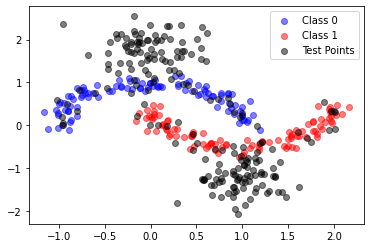

In [3]:
# Generate a toy dataset for classification (Gaussian Blobs)
x_moon, y_moon = make_moons(n_samples=2*samples, shuffle=False, noise=0.1, random_state=None)

# generate test points
test_points_moons, test_points_labels_moons = generate_exp1_test_data_moons()

plot_training_data(x_moon, y_moon, samples, test=test_points_moons)

## Training the Models

Now that we've defined our training and test sets, we can train our models. We will
start with a determinstic neural network model, who's parameters will be used to set
the architecture of more complex models. 

### A Deterministic Neural Network Model

#### Training for Gaussian Blobs

In [4]:
# Deterministic model 
###relu activation
activation_fn_type = 'relu' #'leaky_relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x) #np.maximum(np.ones(x.shape)*1e-3, x) #WARNING: CHANGED THIS TO LEAKY RELU

###neural network model design choices
width = 4
hidden_layers = 2
input_dim = x_train.shape[1]
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [5]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}
        
#fit my neural network to minimize MSE on the given data
nn.fit(x_train.T, y_train.reshape((1,-1)), params, reg_param = 0.0002)

Iteration 0 lower bound 766.9339980596093; gradient mag: 1366.0952769796393
Iteration 500 lower bound 41.03301071189165; gradient mag: 84.56752634669454
Iteration 1000 lower bound 13.419432762612656; gradient mag: 21.859354724634013
Iteration 1500 lower bound 8.622164899764433; gradient mag: 10.314546793745821
Iteration 2000 lower bound 6.3926404277482; gradient mag: 5.538489010669643
Iteration 2500 lower bound 5.18142425961825; gradient mag: 3.969310526095748
Iteration 3000 lower bound 4.574512435688331; gradient mag: 2.6760060518529563
Iteration 3500 lower bound 4.1987252371629795; gradient mag: 2.297248969699808
Iteration 4000 lower bound 3.9118717000189855; gradient mag: 2.280647774335197
Iteration 4500 lower bound 3.6388041198384906; gradient mag: 2.3055541958036


#### Training for Crescent Moons

In [6]:
###neural network model design choices
width = 5
hidden_layers = 3
input_dim = x_train.shape[1]
output_dim = 1

architecture_moons = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#instantiate a Feedforward neural network object
nn_moons = Feedforward(architecture_moons, random=random)

In [7]:
nn_moons.fit(x_moon.T, y_moon.reshape((1,-1)), params, reg_param = 0.0002)

Iteration 0 lower bound 925.2585933500839; gradient mag: 1644.549764822108
Iteration 500 lower bound 37.05715483012471; gradient mag: 35.078481982026084
Iteration 1000 lower bound 19.60738618068636; gradient mag: 36.99168663085941
Iteration 1500 lower bound 8.717648815361922; gradient mag: 20.341369857759826
Iteration 2000 lower bound 4.546541811741861; gradient mag: 11.663049741478405
Iteration 2500 lower bound 2.518391133523046; gradient mag: 7.198469981419851
Iteration 3000 lower bound 1.4808013477232704; gradient mag: 4.677962348643879
Iteration 3500 lower bound 0.9246274254878678; gradient mag: 3.5429217892239215
Iteration 4000 lower bound 0.5875735205068479; gradient mag: 2.215243919662667
Iteration 4500 lower bound 0.3828274866804888; gradient mag: 1.6394698914749137


### Deep Ensemble Neural Networks

Using the same architecture as the deterministic network, we can randomly initialize
the weights in new states to generate an ensemble of neural network models. Below, we
construct an ensemble consisting of 20 samples.

#### Training for Gaussian Blobs

In [11]:
# Deep ensemble
reg_param = 0.0002
random = np.random.RandomState(rand_state)
N_bootstrap = 20

# load existing data
if os.path.exists('data/exp1_deep_ensemble0.pkl'):
    w_bootstrap = [] 
    nn_all = []
    for i in range(N_bootstrap):
        weights_here = pickle.load(open("data/exp1_deep_ensemble" + str(i) + ".pkl", "rb"))
        w_bootstrap.append(weights_here)

        #set random state to make the experiments replicable
        rand_state = 0
        random = np.random.RandomState(rand_state)
        nn_here = Feedforward(architecture, random=random)
        nn_here.weights = weights_here
        nn_all.append(nn_here)

# if no existing data, do a new run
else: 
    nn_all, w_bootstrap = ensemble(x_train, y_train, Feedforward, architecture, params, random, N_bootstrap, reg_param)
    
    # save data 
    masterdir = os.getcwd()
    for (i,nn_temp) in enumerate(nn_all):
        with open('data/exp1_deep_ensemble' + str(i) + '.pkl', 'wb') as f:
            pickle.dump(nn_temp.weights, f, pickle.HIGHEST_PROTOCOL)

Iteration 0 lower bound 733.2528439609791; gradient mag: 1278.2178636675817
Iteration 500 lower bound 36.374371636120785; gradient mag: 76.25505389235138
Iteration 1000 lower bound 12.593680236022255; gradient mag: 20.917107034275226
Iteration 1500 lower bound 7.846303769771447; gradient mag: 10.613790697742164
Iteration 2000 lower bound 5.689297487533054; gradient mag: 5.836575061762728
Iteration 2500 lower bound 4.660781857102629; gradient mag: 3.9461178043440133
Iteration 3000 lower bound 4.107215669131603; gradient mag: 2.1850737429709595
Iteration 3500 lower bound 3.826514313295952; gradient mag: 1.5289334781053263
Iteration 4000 lower bound 3.6262111127822503; gradient mag: 1.306438891734613
Iteration 4500 lower bound 3.4465102045867293; gradient mag: 4.1435875987687965
Calculations done 0/20
Iteration 0 lower bound 823.3630373301037; gradient mag: 998.01331566727
Iteration 500 lower bound 26.60435150405144; gradient mag: 75.84184151689233
Iteration 1000 lower bound 8.98320529491

#### Training for Crescent Moons

In [12]:
random = np.random.RandomState(rand_state)

# load existing data
if os.path.exists('data/exp1_moons_deep_ensemble0.pkl'):
    w_bootstrap_moons = [] 
    nn_all_moons = []
    for i in range(N_bootstrap):
        weights_here = pickle.load(open("data/exp1_moons_deep_ensemble" + str(i) + ".pkl", "rb"))
        w_bootstrap_moons.append(weights_here)

        #set random state to make the experiments replicable
        rand_state = 0
        random = np.random.RandomState(rand_state)
        nn_here = Feedforward(architecture_moons, random=random)
        nn_here.weights = weights_here
        nn_all_moons.append(nn_here)

# if no existing data, do a new run
else: 
    nn_all_moons, w_bootstrap_moons = ensemble(x_moon, y_moon, Feedforward, architecture_moons, params, random, N_bootstrap, reg_param)
    
    # save data 
    masterdir = os.getcwd()
    for (i,nn_temp) in enumerate(nn_all_moons):
        with open('data/exp1_moons_deep_ensemble' + str(i) + '.pkl', 'wb') as f:
            pickle.dump(nn_temp.weights, f, pickle.HIGHEST_PROTOCOL)

Iteration 0 lower bound 168.87268241533937; gradient mag: 133.71334995098607
Iteration 500 lower bound 32.50764357675581; gradient mag: 40.30400506785967
Iteration 1000 lower bound 8.891863140460071; gradient mag: 8.809473019601485
Iteration 1500 lower bound 3.089465586563454; gradient mag: 3.933708748841934
Iteration 2000 lower bound 1.3487433415608818; gradient mag: 2.1989315626462296
Iteration 2500 lower bound 0.5116048444999094; gradient mag: 1.3148802586378878
Iteration 3000 lower bound 0.2807783706818271; gradient mag: 0.9563484545496627
Iteration 3500 lower bound 0.1731907911622106; gradient mag: 2.384224847356215
Iteration 4000 lower bound 0.11357896764686426; gradient mag: 0.5299527175363989
Iteration 4500 lower bound 0.07676069352407701; gradient mag: 0.39056847886159457
Calculations done 0/20
Iteration 0 lower bound 164.43995724549612; gradient mag: 83.60409295673038
Iteration 500 lower bound 36.97993798036577; gradient mag: 35.1019916303609
Iteration 1000 lower bound 8.8854

### Monte Carlo (MC) Dropout

Rather than intializing the weights in new random states for every training pass,
we can perform MC dropout where each weight in the network has a non-zero probability
of being set to zero for each pass through the network (both during training and at
inference). Below, we train a network using MC dropout, and when we make predictions 
later on, we will generate an ensemble of predictions by randomly selecting weights to
zero out some $N$ number of times.

#### Training for Gaussian Blobs

In [13]:
# MC dropout

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

width = 4
hidden_layers = 2
input_dim = x_train.shape[1]
output_dim = 1

architecture_dropout = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'dropout_rate': 0.1,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}


#instantiate a Feedforward neural network object
nn_dropout = Feedforward_Dropout(architecture_dropout, random=random)

params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1}
#fit my neural network to minimize MSE on the given data
nn_dropout.fit(x_train.T, y_train.reshape((1,-1)), params, reg_param = .001)

Iteration 0 lower bound 1072.446326953977; gradient mag: 1333.8837440536358
Iteration 500 lower bound 56.62572365573737; gradient mag: 95.91444535554642
Iteration 1000 lower bound 49.22640179893118; gradient mag: 337.0581743811673
Iteration 1500 lower bound 23.2326313289629; gradient mag: 42.569244845864354
Iteration 2000 lower bound 32.51684911939868; gradient mag: 61.818392464642685
Iteration 2500 lower bound 60.44987562968129; gradient mag: 31.649937694186853
Iteration 3000 lower bound 19.114833163414318; gradient mag: 140.83624356603104
Iteration 3500 lower bound 11.51458887603078; gradient mag: 4.187111599260966
Iteration 4000 lower bound 8.24435262863823; gradient mag: 61.62206451718904
Iteration 4500 lower bound 28.153306429843024; gradient mag: 93.34297740314209
Iteration 5000 lower bound 25.61154096625267; gradient mag: 26.822967184693205
Iteration 5500 lower bound 7.380606368712451; gradient mag: 9.588676600413311
Iteration 6000 lower bound 8.236503505237147; gradient mag: 11

#### Training for Crescent Moons

In [14]:
rand_state = 0
random = np.random.RandomState(rand_state)

width = 5
hidden_layers = 3
input_dim = x_moon.shape[1]
output_dim = 1

architecture_dropout_moons = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'dropout_rate': 0.01,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#instantiate a Feedforward neural network object
nn_dropout_moons = Feedforward_Dropout(architecture_dropout_moons, random=random)

params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn_dropout_moons.fit(x_moon.T, y_moon.reshape((1,-1)), params, reg_param = .001)

Iteration 0 lower bound 171.67139273418314; gradient mag: 115.97708852808562
Iteration 500 lower bound 53.14829069726996; gradient mag: 61.04881525275481
Iteration 1000 lower bound 26.854567122788616; gradient mag: 23.96041060992934
Iteration 1500 lower bound 21.134362053448893; gradient mag: 131.30440249980558
Iteration 2000 lower bound 17.77012182303594; gradient mag: 16.591078786225527
Iteration 2500 lower bound 16.44214563119218; gradient mag: 22.23236502226937
Iteration 3000 lower bound 13.084119090147919; gradient mag: 27.616281569363718
Iteration 3500 lower bound 12.128863325529826; gradient mag: 273.7338041426031
Iteration 4000 lower bound 53.037328387327854; gradient mag: 29.571462172030692
Iteration 4500 lower bound 80.15456958711755; gradient mag: 30.16281919955665
Iteration 5000 lower bound 24.254689669695843; gradient mag: 16.190406332614693
Iteration 5500 lower bound 27.738011076381543; gradient mag: 11.17764858113088
Iteration 6000 lower bound 5.696169637367611; gradient

### Mean Field Variational Inference (MFVI)

To perform variational inference, we will use the parameters of the deterministic
neural network model as the starting guess for the means of the distributions of each
weight. 

#### Training for Gaussian Blobs

In [23]:
## BBVI

S = 20
max_iteration = 10000
step_size = 1e-3

Sigma_W = np.eye(nn.D)*25
sigma_y = 1

# load existing data
if os.path.exists('data/exp1_bbvi.pkl'):

    variational_params = pickle.load(open("data/exp1_bbvi.pkl", "rb"))
    
    var_means = variational_params[0:nn.D]
    var_variance = np.exp(variational_params[nn.D:])**2

# if no existing data, do a new run
else: 
    variational_params = variational_inference(Sigma_W, sigma_y, y_train, x_train.T, nn, nn.forward, S, max_iteration, step_size, 1)

    var_means = variational_params[0:nn.D]
    var_variance = np.exp(variational_params[nn.D:])**2
    
    with open('data/exp1_bbvi.pkl', 'wb') as f:
        pickle.dump(variational_params, f, pickle.HIGHEST_PROTOCOL)

Optimizing variational parameters...
Iteration 0 lower bound -416.59805077010157; gradient mag: 7.586882072952186
Iteration 100 lower bound -412.6134364541907; gradient mag: 6.3544641947278215
Iteration 200 lower bound -408.69317141741277; gradient mag: 7.182711682713147
Iteration 300 lower bound -404.80810625040885; gradient mag: 6.574469950140755
Iteration 400 lower bound -400.95108917043865; gradient mag: 7.001793059644213
Iteration 500 lower bound -397.1095466206242; gradient mag: 6.346062104944818
Iteration 600 lower bound -393.2837566324391; gradient mag: 6.530605787436246
Iteration 700 lower bound -389.4715828118891; gradient mag: 7.0255543438502475
Iteration 800 lower bound -385.6680365099937; gradient mag: 7.142567084734957
Iteration 900 lower bound -381.87146115371434; gradient mag: 6.912126432310205
Iteration 1000 lower bound -378.08721449654445; gradient mag: 6.163140015314341
Iteration 1100 lower bound -374.314379057276; gradient mag: 7.279971294657857
Iteration 1200 lower

#### Training for Crescent Moons

In [24]:
Sigma_W = np.eye(nn_moons.D)*25
sigma_y = 1


# load existing data
if os.path.exists('data/exp1_moons_bbvi.pkl'):

    variational_params_moons = pickle.load(open("data/exp1_moons_bbvi.pkl", "rb"))
    
    var_means_moons = variational_params_moons[0:nn_moons.D]
    var_variance_moons = np.exp(variational_params_moons[nn_moons.D:])**2

# if no existing data, do a new run
else: 
    variational_params_moons = variational_inference(Sigma_W, sigma_y, y_moon, x_moon.T, nn_moons, nn_moons.forward, S, max_iteration, step_size, 1)

    var_means_moons = variational_params_moons[0:nn_moons.D]
    var_variance_moons = np.exp(variational_params_moons[nn_moons.D:])**2
    
    with open('data/exp1_moons_bbvi.pkl', 'wb') as f:
        pickle.dump(variational_params_moons, f, pickle.HIGHEST_PROTOCOL)

Optimizing variational parameters...
Iteration 0 lower bound -902.5424860494663; gradient mag: 9.043764179818169
Iteration 100 lower bound -894.1604975903222; gradient mag: 9.010696918055105
Iteration 200 lower bound -885.8572777117761; gradient mag: 9.0118953760259
Iteration 300 lower bound -877.5893022294199; gradient mag: 9.012974311553885
Iteration 400 lower bound -869.348200004877; gradient mag: 9.013866047558619
Iteration 500 lower bound -861.1293334206388; gradient mag: 9.007207300289906
Iteration 600 lower bound -852.9286695495637; gradient mag: 9.00467536328213
Iteration 700 lower bound -844.7429581225382; gradient mag: 9.008782982183247
Iteration 800 lower bound -836.5697515692015; gradient mag: 9.002301607067096
Iteration 900 lower bound -828.4069958168255; gradient mag: 9.003465783977003
Iteration 1000 lower bound -820.2535362266888; gradient mag: 9.00327985029841
Iteration 1100 lower bound -812.1079751732766; gradient mag: 9.010498015306249
Iteration 1200 lower bound -803.

## Visualizing Decision Boundaries

/work/am207/baselines.py:506: UserWarning: No contour levels were found within the data range.
  CS=ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line,levels=[-0.5,0.5, 1.5])


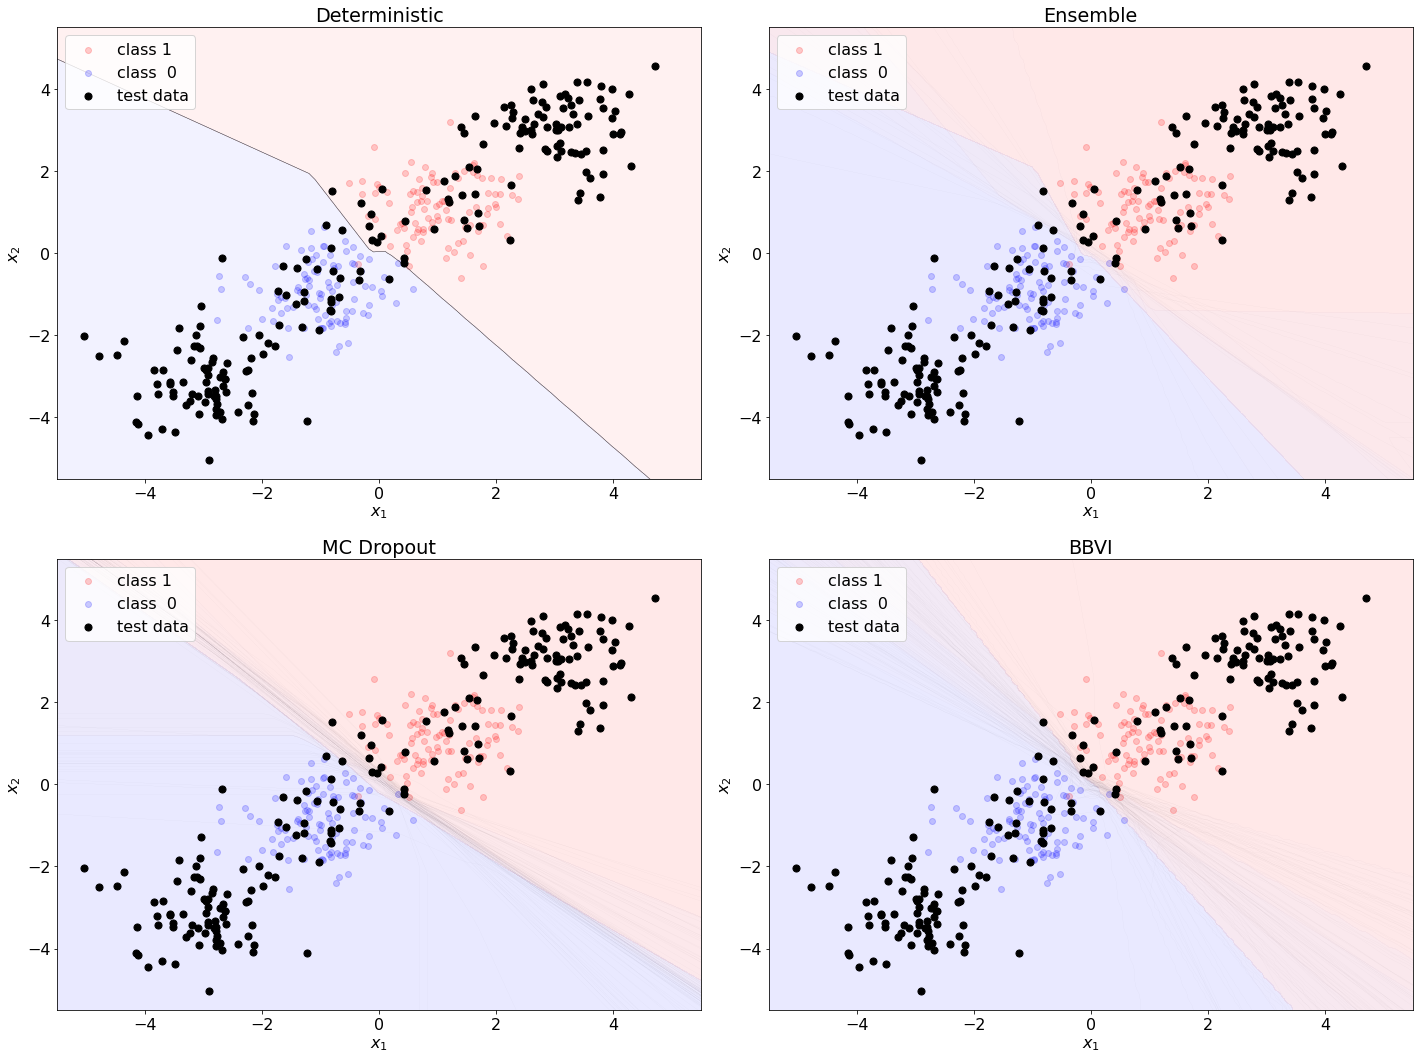

/opt/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


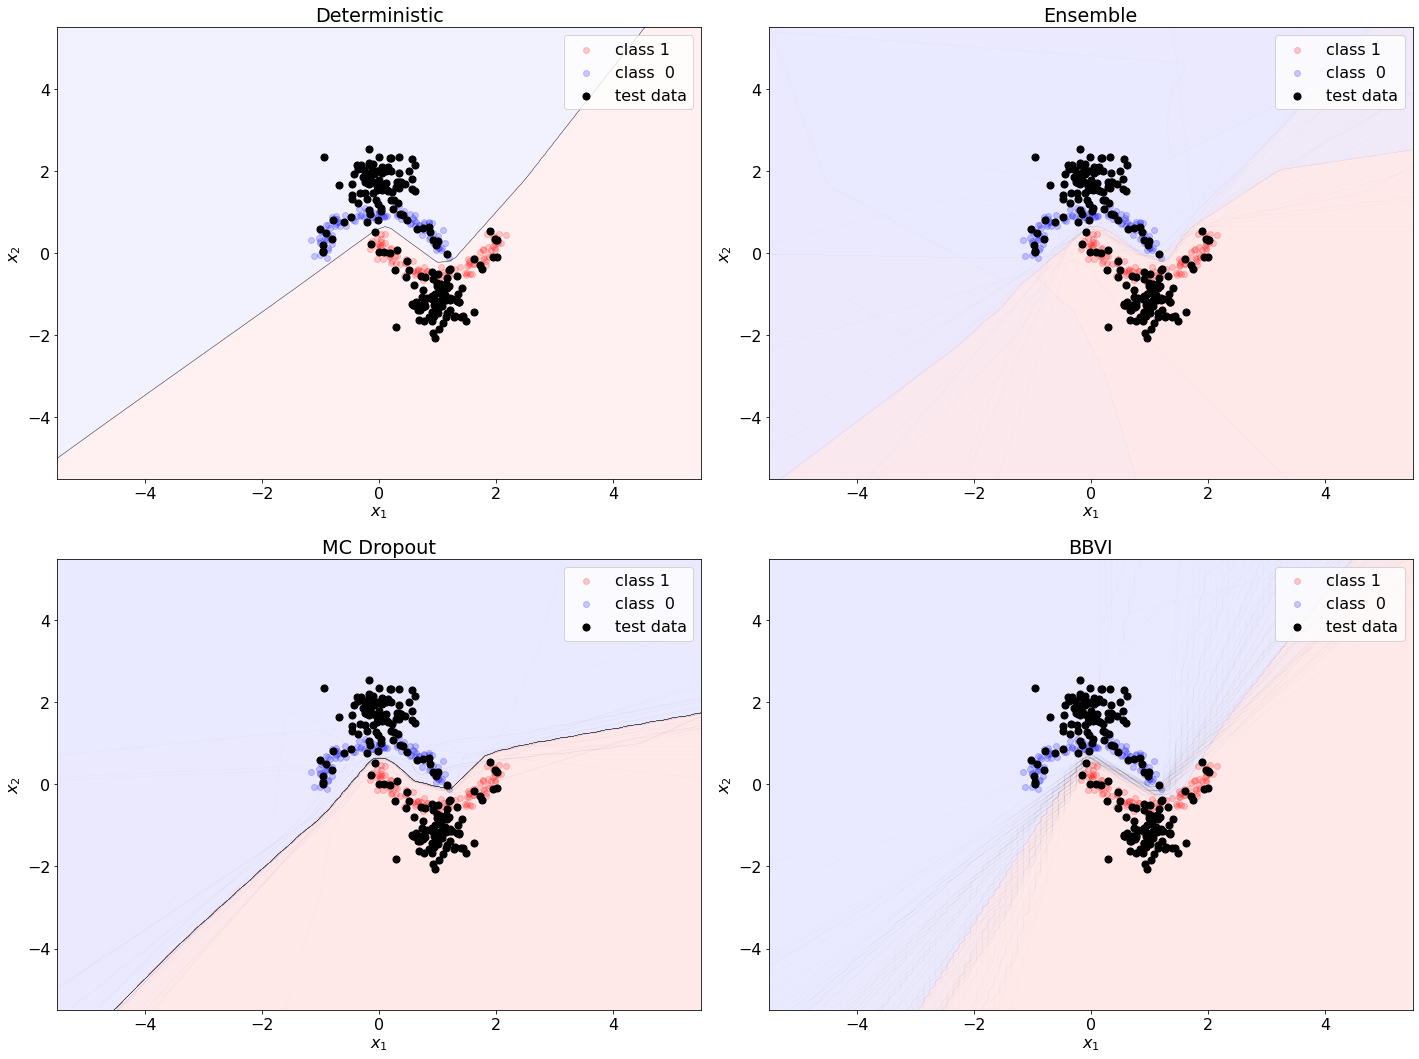

In [25]:
# generate lists of neural networks for plotting BBVI
posterior_sample_size = 100
nn_list = []
nn_list_moons = []
for i in range(posterior_sample_size):
    #set random state to make the experiments replicable
    rand_state = 0
    random = np.random.RandomState(rand_state)

    tempNN = Feedforward(architecture, random=random)
    tempNN_moons = Feedforward(architecture_moons, random=random)

    tempNN.weights = np.random.multivariate_normal(var_means, np.diag(var_variance)).reshape((1,var_means.shape[0]))
    tempNN_moons.weights = np.random.multivariate_normal(var_means_moons, np.diag(var_variance_moons)).reshape((1,var_means_moons.shape[0]))

    nn_list.append(tempNN)
    nn_list_moons.append(tempNN_moons)

#### PLOT

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
k = 0 
models = ['Deterministic', 'Ensemble', 'MC Dropout', 'BBVI']
for i in range(2):
    for j in range(2):
        
        ax[i][j].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
        ax[i][j].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class  0')
        if k == 0: 
            nn_here = [nn]
        elif k == 1: 
            nn_here = nn_all 
        elif k == 2: 
            nn_here = [nn_dropout]*100
        elif k == 3: 
            nn_here = nn_list
        plot_decision_boundary(x_train, y_train, nn_here, ax[i][j], poly_degree=1, test_points=test_points, shaded=True)
        ax[i][j].set_xlabel('$x_1$')
        ax[i][j].set_ylabel('$x_2$')
        ax[i][j].set_title(models[k])
        ax[i][j].legend(loc='best')
        k+= 1 
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
k = 0 
for i in range(2):
    for j in range(2):
        
        ax[i][j].scatter(x_moon[y_moon == 1, 0], x_moon[y_moon == 1, 1], alpha=0.2, c='red', label='class 1')
        ax[i][j].scatter(x_moon[y_moon == 0, 0], x_moon[y_moon == 0, 1], alpha=0.2, c='blue', label='class  0')
        if k == 0: 
            nn_here = [nn_moons]
        elif k == 1: 
            nn_here = nn_all_moons 
        elif k == 2: 
            nn_here = [nn_dropout_moons]*100
        elif k == 3: 
            nn_here = nn_list_moons
        plot_decision_boundary(x_moon, y_moon, nn_here, ax[i][j], poly_degree=1, test_points=test_points_moons, shaded=True)
        ax[i][j].set_xlabel('$x_1$')
        ax[i][j].set_ylabel('$x_2$')
        ax[i][j].set_title(models[k])
        ax[i][j].legend(loc='best')
        k+= 1 
plt.tight_layout()
plt.show()


## Accuracy Versus Referal Rate

### Gaussian Blobs

/opt/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/work/am207/uncertainty.py:43: RuntimeWarning: invalid value encountered in multiply
  Hpredcheck = -p1narray*np.log(p1narray) - p2narray*np.log(p2narray)


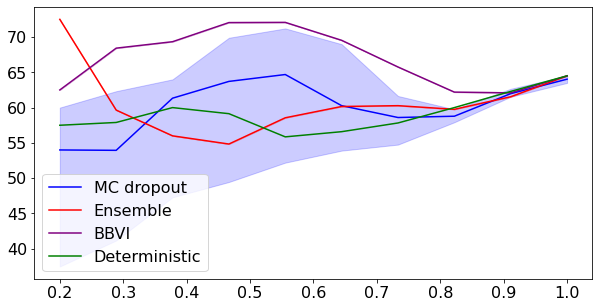

In [26]:
# uncertainty metric
samples = 1000 
n_run = 100 # the number of times to call the NN for predicative entropy 
N = 20

posterior_samples = np.random.multivariate_normal(var_means, np.diag(var_variance), size=posterior_sample_size)

retain_perc = np.linspace(0.2, 1, 10)
auc = np.zeros([len(retain_perc),N])
auc_det = np.zeros([len(retain_perc),N])
auc_ens = np.zeros([len(retain_perc),N])
auc_bbvi = np.zeros([len(retain_perc),N])
for (i, perc) in enumerate(retain_perc):
    for j in range(N):
        auc[i,j] = auc_calc(test_points, test_points_labels, nn_dropout, N, perc, "mc")
        auc_bbvi[i,j] = auc_calc(test_points, test_points_labels, nn, N, perc, "bbvi", weightlist=posterior_samples)
        
    auc_ens[i,:] = auc_calc(test_points, test_points_labels, nn_all, 1, perc, "ensemble")

    # use sigmoid probability for retaining data
    auc_det[i,:] = auc_calc(test_points, test_points_labels, nn, N, perc, "deterministic")

auc_ub = np.percentile(auc, 97.5, axis=1)
auc_lb = np.percentile(auc, 2.5, axis=1)

auc_ub_ens = np.percentile(auc_ens, 97.5, axis=1)
auc_lb_ens = np.percentile(auc_ens, 2.5, axis=1)

auc_ub_bbvi = np.percentile(auc_bbvi, 97.5, axis=1)
auc_lb_bbvi = np.percentile(auc_bbvi, 2.5, axis=1)

fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.fill_between(retain_perc, auc_ub, auc_lb, color='blue', alpha=0.2)
ax.plot(retain_perc, np.mean(auc,axis=1), 'blue', label='MC dropout')
ax.plot(retain_perc, np.mean(auc_ens,axis=1), 'red', label='Ensemble')
ax.plot(retain_perc, np.mean(auc_bbvi,axis=1), 'purple', label='BBVI')
ax.plot(retain_perc, np.mean(auc_det,axis=1), 'green', label='Deterministic')
ax.fill_between(retain_perc, auc_ub_bbvi, auc_lb_bbvi, color='purple', alpha=0.2)
ax.fill_between(retain_perc, auc_ub_ens, auc_lb_ens, color='red', alpha=0.2)
ax.legend()
plt.show()

### Crescent Moons

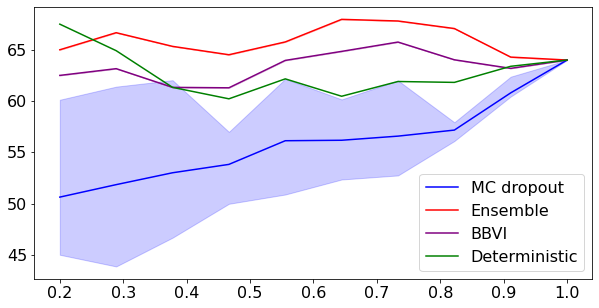

In [27]:
# uncertainty metric
samples = 1000 
n_run = 100 # the number of times to call the NN for predicative entropy 
N = 20

posterior_samples_moons = np.random.multivariate_normal(var_means_moons, np.diag(var_variance_moons), size=posterior_sample_size)

retain_perc = np.linspace(0.2, 1, 10)
auc = np.zeros([len(retain_perc),N])
auc_det = np.zeros([len(retain_perc),N])
auc_ens = np.zeros([len(retain_perc),N])
auc_bbvi = np.zeros([len(retain_perc),N])
for (i, perc) in enumerate(retain_perc):
    for j in range(N):
        auc[i,j] = auc_calc(test_points_moons, test_points_labels_moons, nn_dropout_moons, N, perc, "mc")
        auc_bbvi[i,j] = auc_calc(test_points_moons, test_points_labels_moons, nn_moons, N, perc, "bbvi", weightlist=posterior_samples_moons)
        
    auc_ens[i,:] = auc_calc(test_points_moons, test_points_labels_moons, nn_all_moons, 1, perc, "ensemble")

    # use sigmoid probability for retaining data
    auc_det[i,:] = auc_calc(test_points_moons, test_points_labels_moons, nn_moons, N, perc, "deterministic")

auc_ub = np.percentile(auc, 97.5, axis=1)
auc_lb = np.percentile(auc, 2.5, axis=1)

auc_ub_ens = np.percentile(auc_ens, 97.5, axis=1)
auc_lb_ens = np.percentile(auc_ens, 2.5, axis=1)

auc_ub_bbvi = np.percentile(auc_bbvi, 97.5, axis=1)
auc_lb_bbvi = np.percentile(auc_bbvi, 2.5, axis=1)

fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.fill_between(retain_perc, auc_ub, auc_lb, color='blue', alpha=0.2)
ax.plot(retain_perc, np.mean(auc,axis=1), 'blue', label='MC dropout')
ax.plot(retain_perc, np.mean(auc_ens,axis=1), 'red', label='Ensemble')
ax.plot(retain_perc, np.mean(auc_bbvi,axis=1), 'purple', label='BBVI')
ax.plot(retain_perc, np.mean(auc_det,axis=1), 'green', label='Deterministic')
ax.fill_between(retain_perc, auc_ub_bbvi, auc_lb_bbvi, color='purple', alpha=0.2)
ax.fill_between(retain_perc, auc_ub_ens, auc_lb_ens, color='red', alpha=0.2)
ax.legend()
plt.show()

## Entropy

### Gaussian Blobs

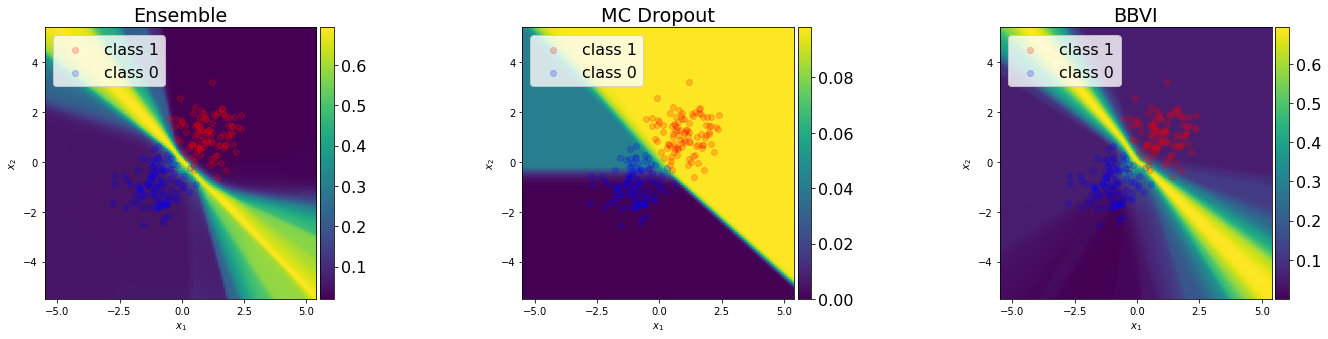

In [30]:
# PLOT ENTROPY FOR GAUSSIAN BLOBS

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
models = ['Ensemble', 'MC Dropout', 'BBVI']
for k in range(3):
    plt.rcParams.update({'font.size': 16})
    ax[k].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
    ax[k].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')
    if k == 0: 
        nn_here = nn_all 
        cl=plot_entropycontours(x_train, y_train, nn_here, w_bootstrap, ax[k], models[k], poly_degree=1, shaded=True)
    
    elif k == 1: 
        nn_here = [nn_dropout]
        weights_here = [nn_dropout.weights]*50
        cl=plot_entropycontours(x_train, y_train, nn_here, weights_here, ax[k], models[k], poly_degree=1, shaded=True)

    elif k == 2: 
        nn_here = nn_list
        cl=plot_entropycontours(x_train, y_train, nn, [posterior_samples[i].reshape((1, -1)) for i in range(posterior_samples.shape[0])], ax[k], models[k], poly_degree=1, shaded=True)
    
    divider = make_axes_locatable(ax[k])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(cl, cax=cax, orientation='vertical');
    ax[k].set_xlabel('$x_1$')
    ax[k].set_ylabel('$x_2$')
    ax[k].set_title(models[k])
    ax[k].legend(loc='best')
    
plt.tight_layout()
plt.show()

### Crescent Moons

/opt/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


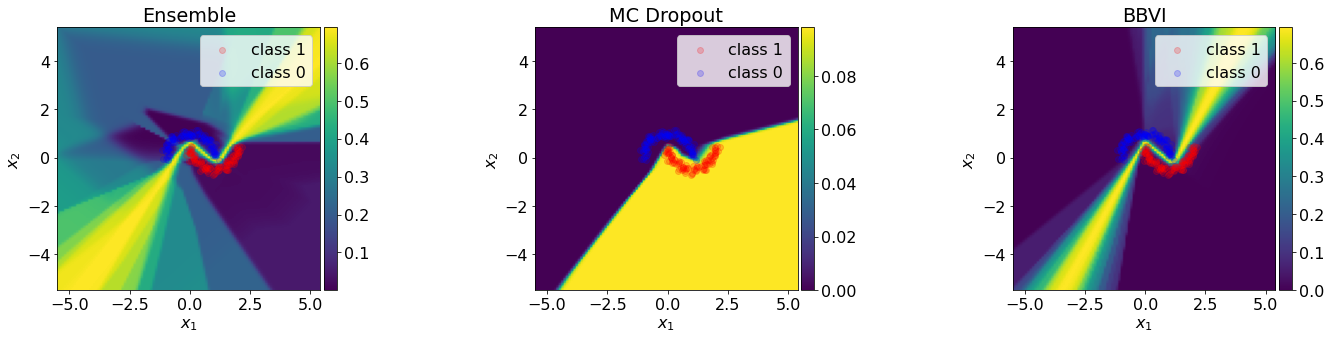

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for k in range(3):
    plt.rcParams.update({'font.size': 16})
    ax[k].scatter(x_moon[y_moon == 1, 0], x_moon[y_moon == 1, 1], alpha=0.2, c='red', label='class 1')
    ax[k].scatter(x_moon[y_moon == 0, 0], x_moon[y_moon == 0, 1], alpha=0.2, c='blue', label='class 0')
    if k == 0: 
        nn_here = nn_all_moons 
        cl=plot_entropycontours(x_moon, y_moon, nn_here, w_bootstrap_moons, ax[k], models[k], poly_degree=1, shaded=True)
    
    elif k == 1: 
        nn_here = [nn_dropout_moons]
        weights_here = [nn_dropout_moons.weights]*50
        cl=plot_entropycontours(x_moon, y_moon, nn_here, weights_here, ax[k], models[k], poly_degree=1, shaded=True)

    elif k == 2: 
        nn_here = nn_list_moons
        cl=plot_entropycontours(x_moon, y_moon, nn_moons, [posterior_samples_moons[i].reshape((1, -1)) for i in range(posterior_samples_moons.shape[0])], ax[k], models[k], poly_degree=1, shaded=True)
    
    divider = make_axes_locatable(ax[k])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(cl, cax=cax, orientation='vertical');
    ax[k].set_xlabel('$x_1$')
    ax[k].set_ylabel('$x_2$')
    ax[k].set_title(models[k])
    ax[k].legend(loc='best')
    
plt.tight_layout()
plt.show()

## Analysis

In our analysis, we wish to understand two things. First, we want to determine whether
the proposed uncertainty metric is indeed sufficient to identify whether any given model 
provides robust uncertainty quantification. That is, are we able to tell whether a model
is giving reasonable uncertainties? The second aspect we want to probe is the claim that
MC drop out performs the best on real life data.

To the first point, we notice immediately the decision boundaries predicted for both 
of the training sets. It's clear that all models for the Gaussian blobs training set,
other than the deterministic neural network, provide varying degrees of uncertainty 
about the decision boundary. However, we note that the variation in the decision 
boundaries is localized to what we might identify as a direction parallel to the sharp
boundary between the training points. On the other hand, there is no variation at all
in the boundaries as we move in the other direction (i.e. where we have placed our test
points). This is problematic because it suggests that all of our models will give poor
uncertainty on these points that are out of distribution.

A similar effect is seen for the crescent moon training set. While moving away from the
training points along the deterministic decision boundary, the uncertainty increases. 
However, looking directly above or below the moons as in our test set, the uncertainty is
nearly zero. 

If we construct accuracy curves for these models and test sets as a function of retained
test points, we see that the proposed uncertainty metric does in fact indicate that the
models we have poorly capture uncertainty on all out of distribution points. As we move
to the left along the x-axis, we retain less data in our test set. However, in all cases,
the accuracy goes down when we do this. This indicates that the model is uncertainty
about things that it should be certain about, and it is certain about things it should 
be uncertain about. 

In the context of our specific test sets, we have included some training points that are
in distribution. These points actually lie closer to the decision boundary, and the model
has increased uncertainty on these than on the other test points that it believes lie
deep within either classification region. Because we have made these out of distribution
points have random classifications to simulate the effect of unknown data on predictions,
the accuracy of our model goes down as it retains less data and gets rid of the points
where it should actually be more certain. 


While this experiment supports the use of the proposed uncertainty metric, it does not
explain the benefit of MC drop out to real life data. 



[ 3.94792834  0.8345357   3.12826058  2.7036527   2.25955897 -2.48716241
  2.44698102 -0.24997102 -0.80725043  0.3630358   0.02735042  1.50936025
 -1.7325428  -1.59056336  0.66951029 -0.96846167 -1.30980523 -1.40426436
  0.11374578 -0.66103947 -2.67672365 -2.02553549  2.13834181 -2.11116855
  2.26945845  2.782496   -1.89641543  0.45850211  0.88394516  0.52010575
  1.45190167 -0.8359366  -1.0811498  -0.77075171 -2.50716341  1.73262966
 -1.23577659 -0.37595252 -0.26811187 -0.46459666 -0.49779972 -0.57085695
 -0.62771309 -0.7220794  -0.74248157 -0.86310294 -1.09815651 -1.25082045
 -1.18814404 -0.06886996 -0.09278945 -0.17831645 -0.2722965  -0.05409005
 -0.08259254 -0.13272204 -0.20253236 -0.04265409 -0.09579816 -0.37159107
 -0.4331404  -0.21836473 -0.37968469 -0.52846987 -0.86925476 -0.20638436
 -0.12904923 -0.66420526 -0.51883093 -0.37097271 -0.2996903  -0.25529297
 -0.73565601 -0.4698805 ]
